In [2]:
from pathlib import Path
import shutil
from face_detect import face_detect,face_crop
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np

path_base="D:/pv2/project/"

In [2]:
with open('test_posetemp_imglist.txt') as file:
    vgg_path_list=[]
    for line in file:
        vgg_path_list.append(line.strip())

<ipython-input-3-bc6305f88fe3>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-3-bc6305f88fe3>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


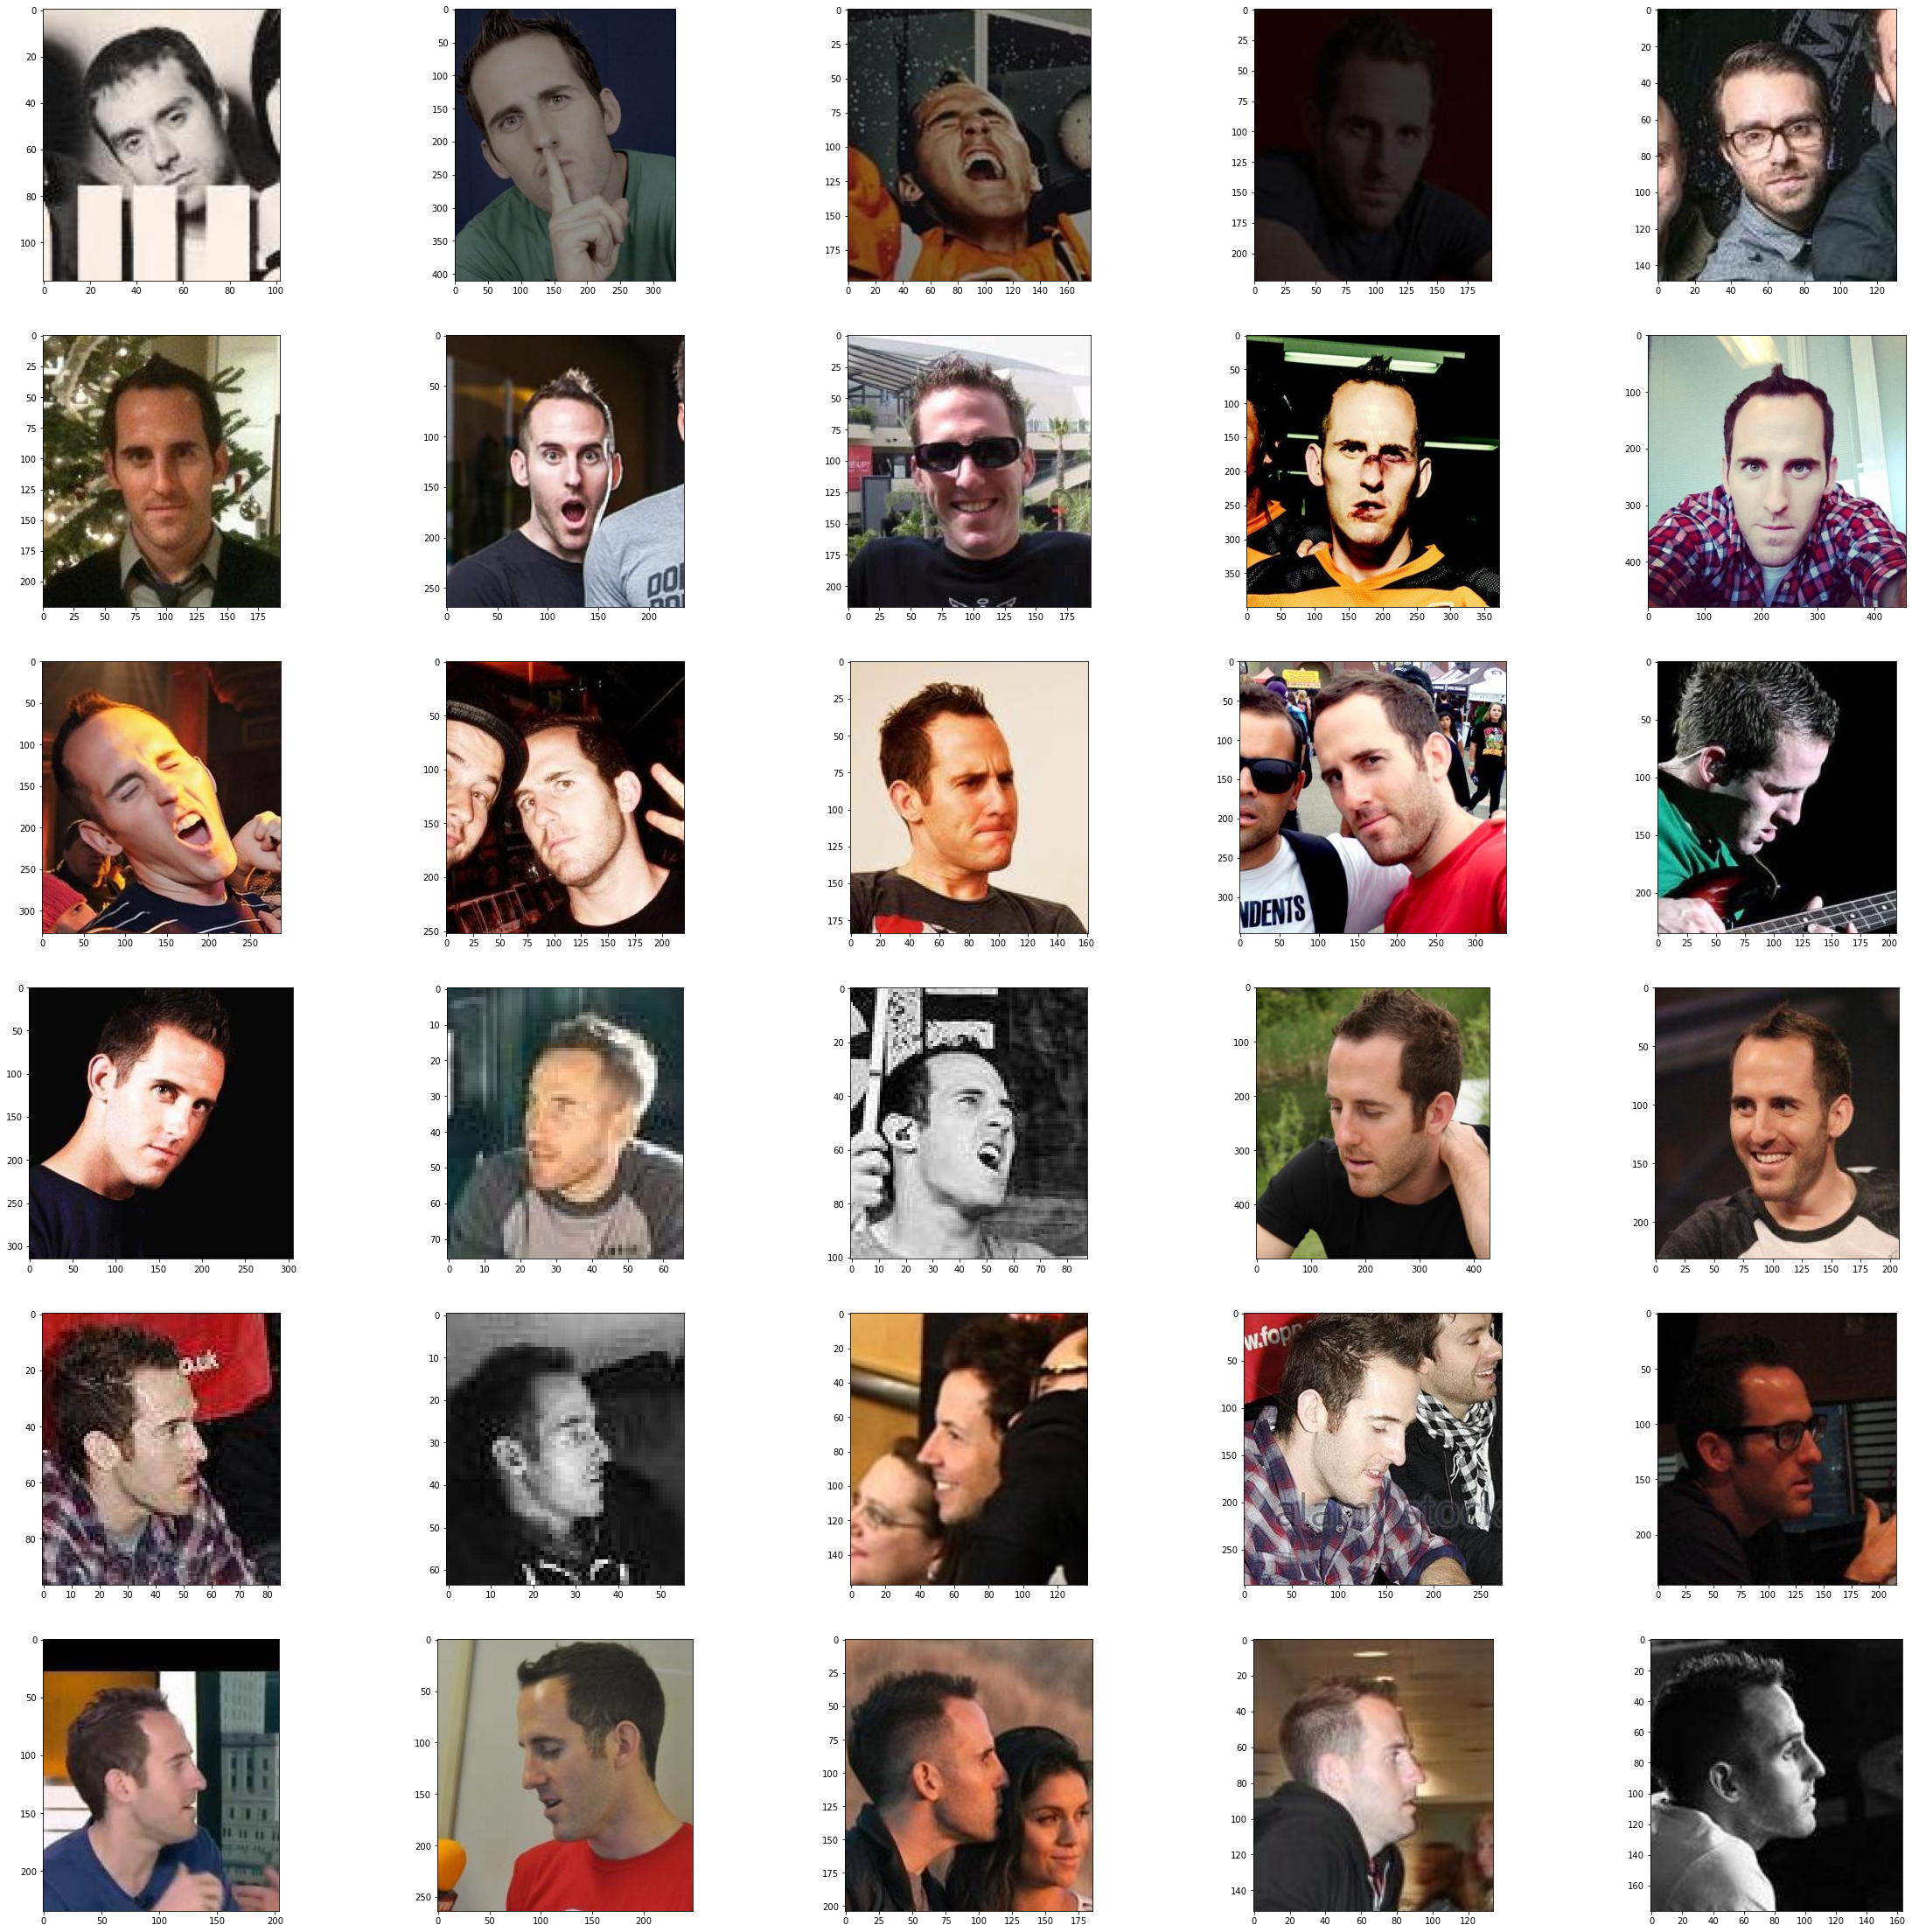

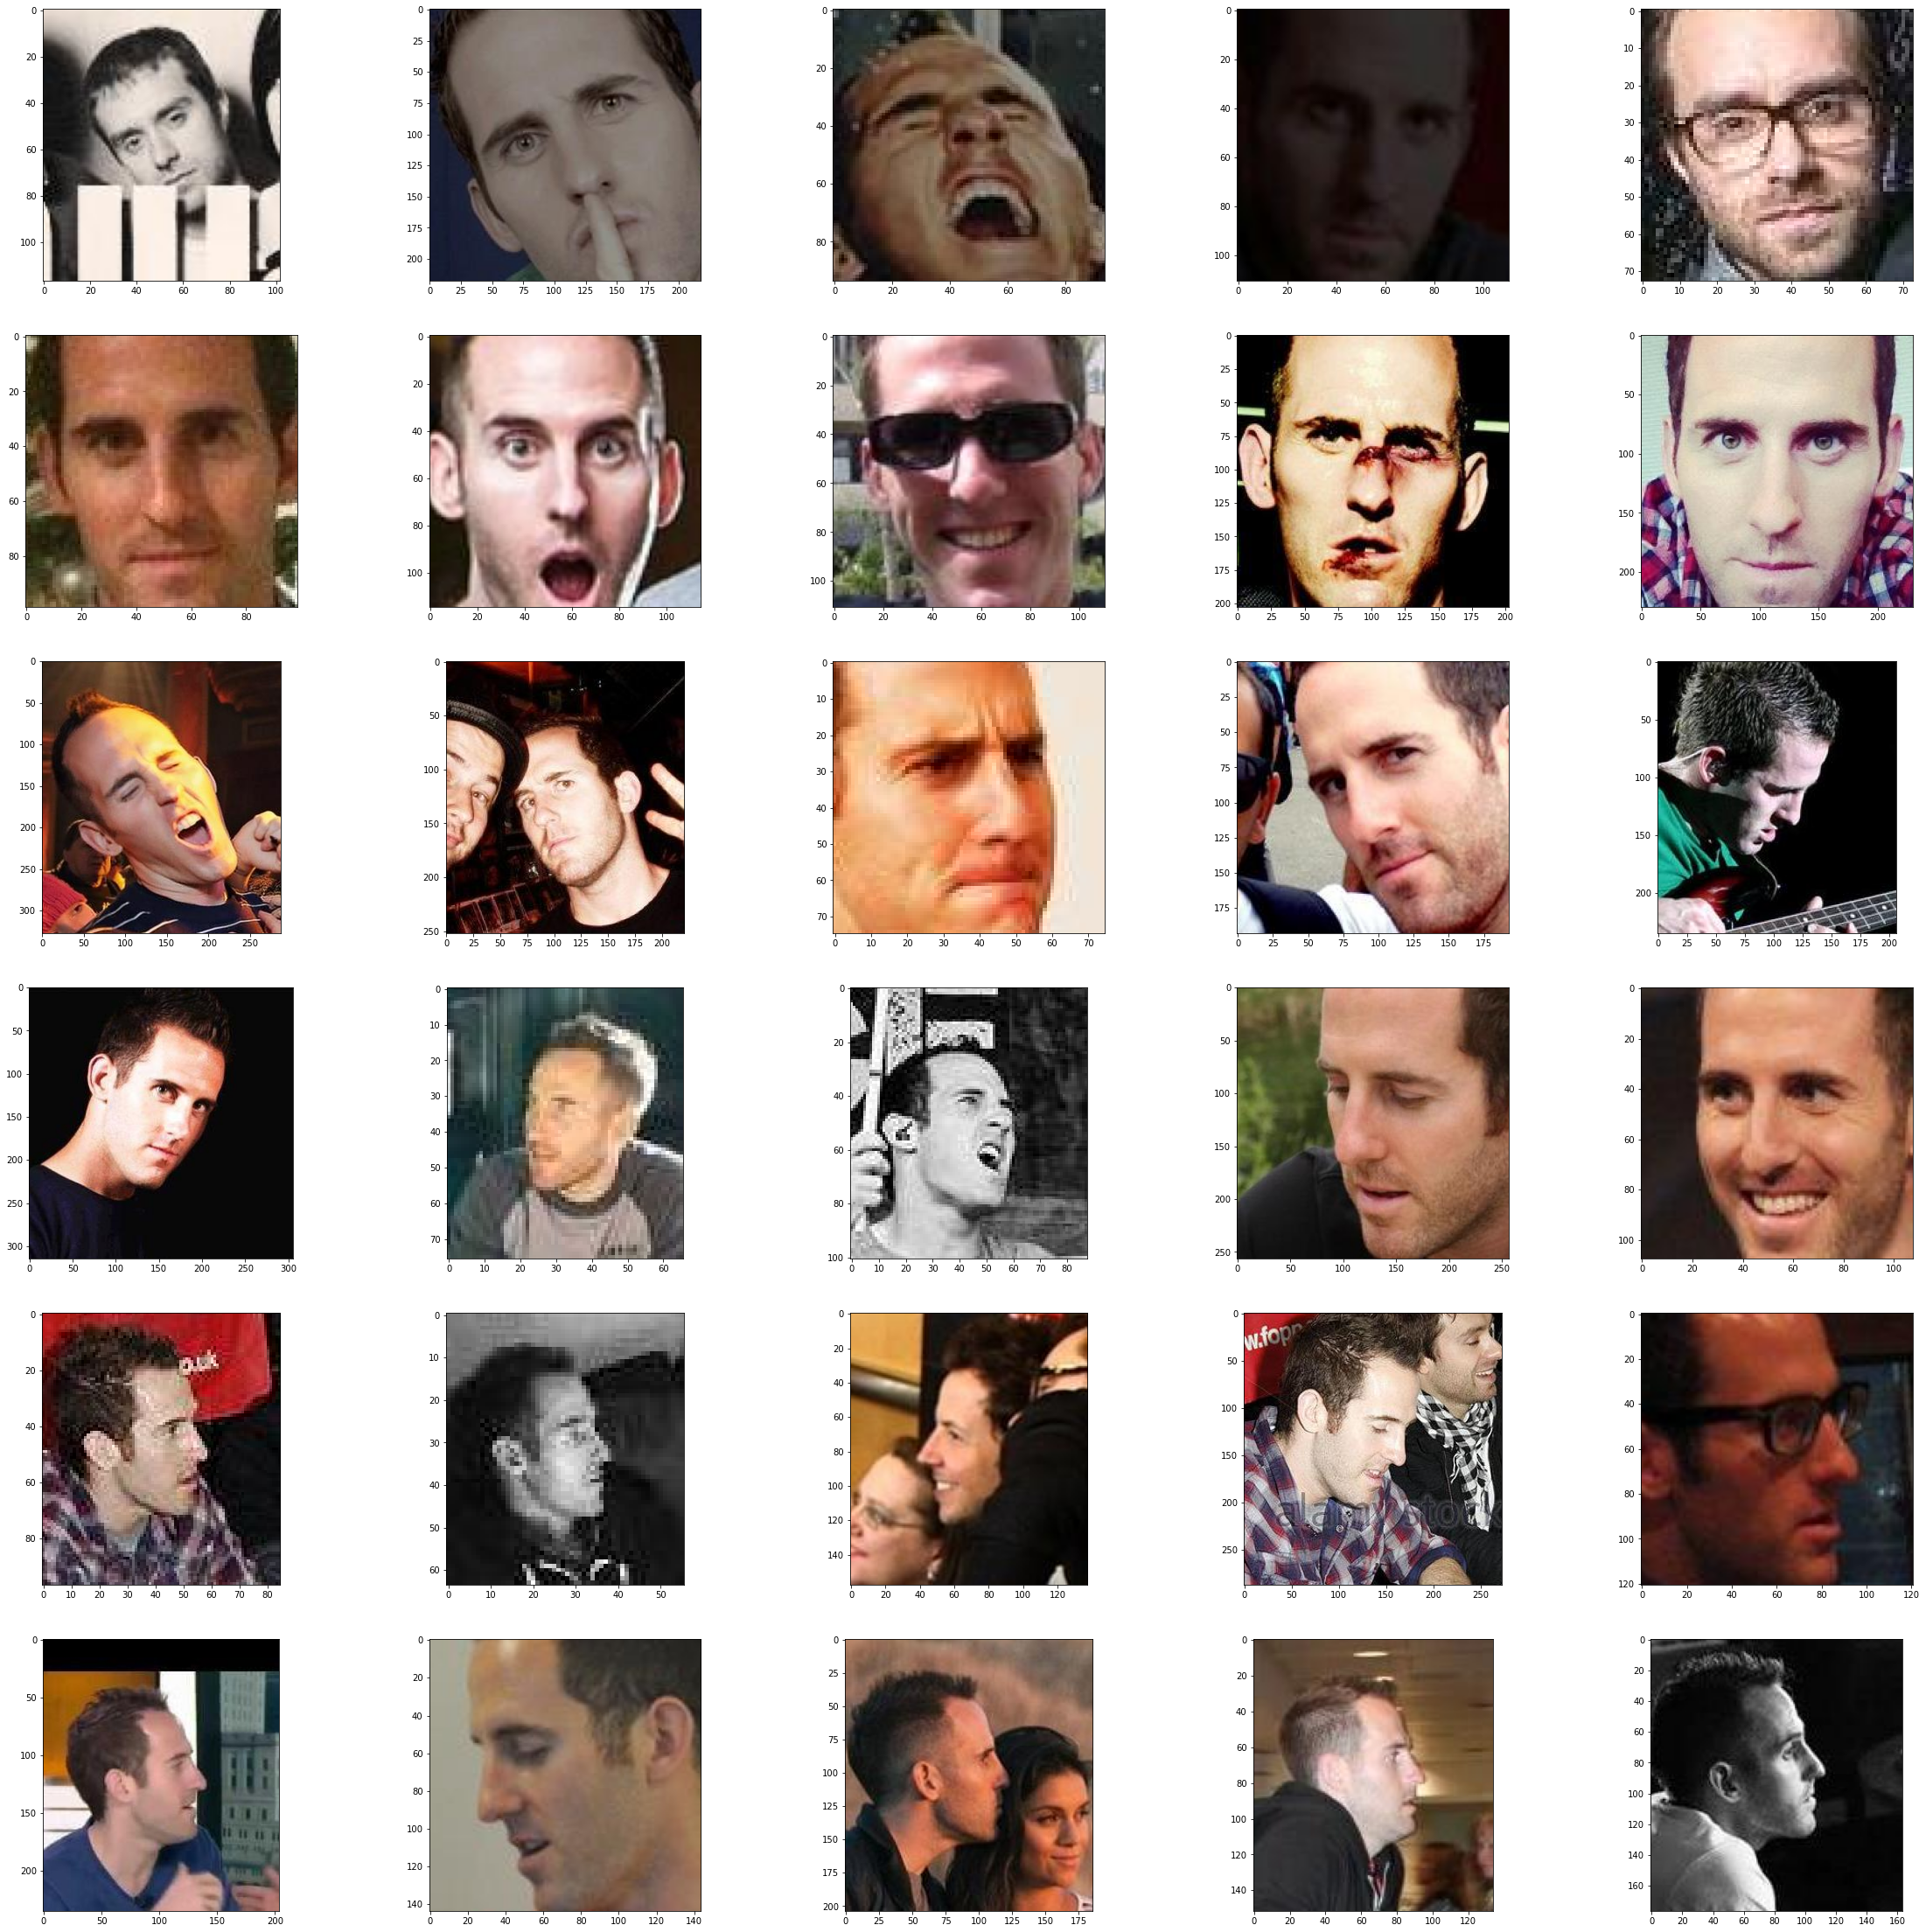

In [3]:
for i in range(60,150,30):
    fig,ax=plt.subplots(6,5,figsize=(40,40))
    fig2,ax2=plt.subplots(6,5,figsize=(40,40))
    for j in range(30):
        try:
            img=plt.imread(path_base+'train/'+vgg_path_list[i*30+j])
        except FileNotFoundError:
            img=plt.imread(path_base+'test/'+vgg_path_list[i*30+j])
        ax.flatten()[j].imshow(img)
        ax2.flatten()[j].imshow(face_crop(img))
    fig.show()
    fig2.show()
    break

In [4]:
#Building dataset

paths=[]
categories=[]

#VGGFaces2
# Each identity has 30 faces, 10 each for "frontal", "3/4 portrait", and "portrait"
# "Frontal" will be treated as "engaged" while the others will be "distracted".
# To offset the 1:2 between "engaged" and "distracted", only half of the "distracted" will be used.
for i in range(0,len(vgg_path_list),30):
    for j in range(10): #0 - 9 = "frontal"
        is_in_train = Path(path_base+'train/'+vgg_path_list[i+j]).is_file()
        p=path_base+('train/' if is_in_train else 'test/')+vgg_path_list[i+j]
        paths.append(Path(p))
        categories.append("0_engaged")
    for j in range(5): #10 - 14 = "distracted"
        is_in_train = Path(path_base+'train/'+vgg_path_list[i+j+10]).is_file()
        p=path_base+('train/' if is_in_train else 'test/')+vgg_path_list[i+j+10]
        paths.append(Path(p))
        categories.append("1_distracted")
    for j in range(5): #20 - 24 = "distracted"
        is_in_train = Path(path_base+'train/'+vgg_path_list[i+j+20]).is_file()
        p=path_base+('train/' if is_in_train else 'test/')+vgg_path_list[i+j+20]
        paths.append(Path(p))
        categories.append("1_distracted")

#closed_eyes
for p in Path(path_base+'asleep').iterdir():
    paths.append(p)
    categories.append("2_asleep")
#absent
for p in Path(path_base+'indoor_rooms').iterdir():
    paths.append(p)
    categories.append("3_absent")

In [5]:
df_all = pd.DataFrame({
    'path':paths,
    'cat':categories
})
df_all.sample(10)

path           cat
5876            D:\pv2\project\test\n006123\0183_01.jpg  1_distracted
4496            D:\pv2\project\test\n004925\0404_01.jpg  1_distracted
8302  D:\pv2\project\asleep\senior-woman-sitting-amo...      2_asleep
6166            D:\pv2\project\test\n007166\0104_01.jpg     0_engaged
725             D:\pv2\project\test\n001153\0088_01.jpg     0_engaged
7060            D:\pv2\project\test\n008653\0309_01.jpg     0_engaged
4583            D:\pv2\project\test\n005101\0238_01.jpg     0_engaged
7336            D:\pv2\project\test\n009235\0214_01.jpg  1_distracted
566             D:\pv2\project\test\n000928\0046_02.jpg     0_engaged
3690            D:\pv2\project\test\n004357\0219_01.jpg  1_distracted

In [6]:
df_all.cat.value_counts()

1_distracted    3680
0_engaged       3680
2_asleep        1121
3_absent        1029
Name: cat, dtype: int64

In [7]:
p_train,p_test,c_train,c_test=train_test_split(df_all.path.values,df_all.cat.values,test_size=0.2,random_state=0)
df_train=pd.DataFrame({
    'path':p_train,
    'cat':c_train
})
df_test=pd.DataFrame({
    'path':p_test,
    'cat':c_test
})

df_train

path           cat
0               D:\pv2\project\test\n001059\1072_02.jpg  1_distracted
1               D:\pv2\project\test\n003134\0421_02.jpg     0_engaged
2               D:\pv2\project\test\n004461\0124_02.jpg     0_engaged
3               D:\pv2\project\test\n004372\0176_03.jpg     0_engaged
4     D:\pv2\project\asleep\closed-eyes-beautiful-wo...      2_asleep
...                                                 ...           ...
7603  D:\pv2\project\asleep\d69ba9e29c8f1f3e0eeeed90...      2_asleep
7604          D:\pv2\project\indoor_rooms\images564.jpg      3_absent
7605            D:\pv2\project\test\n005181\0286_01.jpg  1_distracted
7606            D:\pv2\project\test\n003881\0041_01.jpg     0_engaged
7607            D:\pv2\project\test\n003115\0296_01.jpg  1_distracted

[7608 rows x 2 columns]

In [8]:
df_train['cat'].value_counts()

0_engaged       2949
1_distracted    2933
2_asleep         887
3_absent         839
Name: cat, dtype: int64

In [9]:
#Organize into folders for use in classification
train_imgs_path="img_train/"
for i,row in df_train.iterrows():
    #Save original to new place
    path=row.path
    new_name=str(i)+path.suffix
    new_path=train_imgs_path+row['cat']+'/'+new_name
    Path(new_path).parent.mkdir(parents=True,exist_ok=True)
    shutil.copy(str(path),new_path)
    
    #If category is either 3 or 4, save a flipped copy there as well
    if row['cat'] in ['2_asleep','3_absent']:
        img=Image.open(str(path))
        img=img.transpose(Image.FLIP_LEFT_RIGHT)
        flip_path=train_imgs_path+row['cat']+'/'+str(i)+'_rev'+path.suffix
        img.save(flip_path)

In [10]:
#Organize into folders for use in classification
test_imgs_path="img_test/"
for i,row in df_test.iterrows():
    #Save original to new place
    path=row.path
    new_name=str(i)+path.suffix
    new_path=test_imgs_path+row['cat']+'/'+new_name
    Path(new_path).parent.mkdir(parents=True,exist_ok=True)
    shutil.copy(str(path),new_path)
    
    #If category is either 3 or 4, save a flipped copy there as well
    if row['cat'] in ['2_asleep','3_absent']:
        img=Image.open(str(path))
        img=img.transpose(Image.FLIP_LEFT_RIGHT)
        flip_path=test_imgs_path+row['cat']+'/'+str(i)+'_rev'+path.suffix
        img.save(flip_path)

In [11]:
#Applies face detection and crop to each image
for folder in Path('img_train').iterdir():
    new_folder=Path('c_img_train/'+folder.name)
    new_folder.mkdir(parents=True,exist_ok=True)
    for file in folder.iterdir():
        if file.is_file(): 
            #print(file)
            img=plt.imread(str(file))
            if img.dtype==np.float32: img=(img*255).astype(np.uint8)
            try:
                img=face_crop(img)
            except:
                pass
            Image.fromarray(img).save(str(new_folder)+'/'+file.name)

In [13]:
#Applies face detection and crop to each image
for folder in Path('img_test').iterdir():
    new_folder=Path('c_img_test/'+folder.name)
    new_folder.mkdir(parents=True,exist_ok=True)
    for file in folder.iterdir():
        if file.is_file(): 
            #print(file)
            img=plt.imread(str(file))
            if img.dtype==np.float32: img=(img*255).astype(np.uint8)
            try:
                img=face_crop(img)
            except:
                pass
            Image.fromarray(img).save(str(new_folder)+'/'+file.name)

In [16]:
#turns images into squares
for folder in Path('img_train').iterdir():
    new_folder=Path('s_img_train/'+folder.name)
    new_folder.mkdir(parents=True,exist_ok=True)
    for file in folder.iterdir():
        if file.is_file(): 
            #print(file)
            img=plt.imread(str(file))
            if img.dtype==np.float32: img=(img*255).astype(np.uint8)
            if img.shape[0]>img.shape[1]:
                d=int((img.shape[0]-img.shape[1])/2)
                img_new=img[d:-d-1]
            else:
                d=int((img.shape[1]-img.shape[0])/2)
                img_new=img[:,d:-d-1]
            Image.fromarray(img_new).save(str(new_folder)+'/'+file.name)

In [17]:
#turns images into squares
for folder in Path('img_test').iterdir():
    new_folder=Path('s_img_test/'+folder.name)
    new_folder.mkdir(parents=True,exist_ok=True)
    for file in folder.iterdir():
        if file.is_file(): 
            #print(file)
            img=plt.imread(str(file))
            if img.dtype==np.float32: img=(img*255).astype(np.uint8)
            if img.shape[0]>img.shape[1]:
                d=int((img.shape[0]-img.shape[1])/2)
                img_new=img[d:-d-1]
            else:
                d=int((img.shape[1]-img.shape[0])/2)
                img_new=img[:,d:-d-1]
            Image.fromarray(img_new).save(str(new_folder)+'/'+file.name)